# Requirements

In [6]:
%pip install tensorflow numpy opencv-python-headless firebase_admin google-cloud-storage google-cloud-bigquery google-cloud-aiplatform google-cloud-pipeline-components kfp scikit-image ultralytics

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python311\lib\site-packages\mask_rcnn-2.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [180]:
! pip list > req.txt

DEPRECATION: Loading egg at c:\python311\lib\site-packages\mask_rcnn-2.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

In [1]:
# Importing necessary modules
import tensorflow as tf
import numpy as np
import cv2
import os
import urllib
import pytz
import tempfile
from typing import NamedTuple, List
from skimage.transform import resize
from ultralytics import YOLO
from skimage import io

import firebase_admin
from firebase_admin import firestore, credentials, storage
from datetime import datetime, timedelta
from google.cloud.firestore_v1.base_query import FieldFilter
from google.cloud import storage, bigquery, aiplatform

from kfp.dsl import pipeline, component
from kfp import compiler

2024-02-10 23:33:58.476608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 23:33:58.476650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 23:33:58.502977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-10 23:33:58.558391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-10 23:34:00.618509: W tensorflow/compiler/tf2

# Connect with Firestore

In [9]:
CLOUD_CRED = "./keys/detectionKey.json"
FIREBASE_CRED = "./keys/serviceAccountKey.json"

In [4]:
cred = credentials.Certificate(FIREBASE_CRED)
firebase_admin.initialize_app(cred)

In [5]:
db = firestore.client()

# Getting & Preprocessing Images

In [6]:
# Setting timezone
indian_timezone = pytz.timezone('Asia/Kolkata')

In [7]:
# Getting start date and end date for fetching documents
current_datetime = datetime.now()
midnight_datetime = current_datetime.replace(hour=0, minute=0, second=0, microsecond=0)

one_day = timedelta(days=1)
yesterday_midnight_datetime = current_datetime - one_day
yesterday_midnight_datetime = yesterday_midnight_datetime.replace(hour=0, minute=0, second=0, microsecond=0)

start_date = indian_timezone.localize(yesterday_midnight_datetime)
end_date = indian_timezone.localize(midnight_datetime)

In [21]:
# For the collection Markers
markers = db.collection("Markers").get()
# markers = db.collection("Markers").where(filter=FieldFilter('time', ">=", start_date)).where(filter=FieldFilter('time', "<=", end_date)).get()
markerImages = []

In [17]:
print(len(markers))

42


In [22]:
# For creating markerImages
for obj in markers:
    data = obj.to_dict()
    img = io.imread(data["imageUrl"])
    date = data["time"] if "time" in data.keys() else datetime.now()
    markerImages.append([data["id"], img, date])

In [45]:
markerImages[0][1]

array([[[145, 136, 127],
        [147, 138, 129],
        [148, 139, 130],
        ...,
        [199, 174, 154],
        [194, 169, 149],
        [198, 173, 153]],

       [[145, 136, 127],
        [146, 137, 128],
        [147, 138, 129],
        ...,
        [201, 176, 156],
        [198, 173, 153],
        [200, 175, 155]],

       [[145, 136, 127],
        [146, 137, 128],
        [146, 137, 128],
        ...,
        [202, 177, 157],
        [199, 174, 154],
        [200, 175, 155]],

       ...,

       [[255, 255, 247],
        [255, 255, 247],
        [254, 255, 247],
        ...,
        [ 66,  99, 116],
        [ 61,  94, 113],
        [ 57,  90, 109]],

       [[255, 255, 247],
        [255, 255, 247],
        [254, 255, 247],
        ...,
        [ 65,  98, 115],
        [ 59,  92, 111],
        [ 55,  88, 107]],

       [[255, 255, 247],
        [254, 254, 246],
        [253, 254, 246],
        ...,
        [ 66,  99, 116],
        [ 62,  95, 114],
        [ 60,  93, 112]]

# Loading Model

In [ ]:
# Setting up model class
class human_detection:

    def __init__(self):
        self.model = YOLO("yolov8n.pt")
        self.image_verification = {0: [], 1: []}

    def forward(self, THRESHOLD_SCORE, IMAGE_ARRAY):

        for (image_id, img_init, date) in IMAGE_ARRAY:

            detection = False
            cropped_images = []

            dh, dw, _ = img_init.shape
            results = self.model(img_init)

            # Extract bounding boxes, classes, names, and confidences
            boxes = results[0].boxes.xyxy.tolist()
            classes = results[0].boxes.cls.tolist()
            names = results[0].names
            confidences = results[0].boxes.conf.tolist()

            # Iterate through the results
            for box, cls, conf in zip(boxes, classes, confidences):
                x_min, y_min, x_max, y_max = box
                x_min = int(x_min)
                y_min = int(y_min)
                x_max = int(x_max)
                y_max = int(y_max)
                confidence = conf
                name = names[int(cls)]

                if name == "person":
                    if ((confidence > THRESHOLD_SCORE) and (confidence <= 1.0)):
                        detection = True
                        cropped_images.append(img_init[y_min:y_max, x_min:x_max])

            if detection:
                self.image_verification[1].append((image_id, cropped_images, date))
            else:
                self.image_verification[0].append(image_id)

    def get_dict(self):
        return self.image_verification

In [ ]:
# Initializing Model
model = human_detection()

In [165]:
# Execute model
model.forward(0.6, markerImages)


0: 480x640 4 persons, 1 chair, 1 dining table, 1 tv, 1 laptop, 36.0ms
Speed: 5.0ms preprocess, 36.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 bottles, 1 cup, 4 chairs, 1 dining table, 1 cell phone, 16.0ms
Speed: 4.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 bottles, 1 bed, 1 book, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 4 persons, 3 cars, 1 truck, 1 kite, 14.5ms
Speed: 2.0ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 6 persons, 1 bed, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 2.0ms postpro

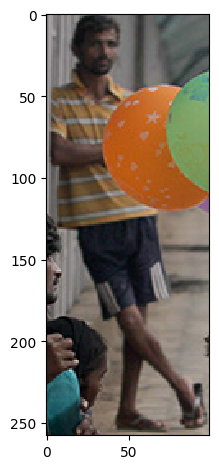

In [180]:
# Get model results

# FORMAT = (Human present markers = 1, individual marker information = M, cropped images = 1, individual images = N)


io.imshow(model.get_dict()[1][2][1][1])

# Connecting to GCP

In [171]:
# Connecting to GCP
storage_client = storage.Client.from_service_account_json(CLOUD_CRED) #type: ignore

# Connecting to Bucket
bucket = storage_client.get_bucket('faces_for_clusters')

In [172]:
# Connecting to BigQuery
bigquery_client = bigquery.Client.from_service_account_json(CLOUD_CRED)

In [184]:
# Connecting to Table
table_ref = bigquery_client.dataset("clustering_dataset").table("faces")
table = bigquery_client.get_table(table_ref)

In [185]:
# List to contain the rows to be inserted
insert_rows = []

In [186]:
# Uploading images to buckets
for (id, cropped_images, date) in model.get_dict()[1]:
    for (num, img) in enumerate(cropped_images):
        with tempfile.TemporaryFile() as temp:
            filename = str(id) + "_" + str(num) + ".png"
            cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            object_name = bucket.blob("CroppedImages/" + filename)
            object_name.upload_from_filename(filename, content_type='image/png')
            url = object_name.public_url
            insert_rows.append((id, url, date))

In [187]:
# Insert rows to table
query = bigquery_client.insert_rows(table, insert_rows)
print(query)

[]


# Testing model on single images

## Loading Pre-trained Efficientdet

In [ ]:
# Creating a TensorFlow Lite Interpreter instance to load a pre-trained model (https://www.kaggle.com/models/tensorflow/efficientdet)
interpreter = tf.lite.Interpreter(model_path="/content/gdrive/MyDrive/hestia_human_detection/1.tflite")

# Allocating tensors for the interpreter to prepare for inference
interpreter.allocate_tensors()

## Loading and Preprocessing image(s)

In [ ]:
# Reading an image using OpenCV from the specified path
img = cv2.imread("/content/gdrive/MyDrive/hestia_human_detection/94921710.jpeg", cv2.IMREAD_UNCHANGED)

imH, imW, _ = img.shape

In [ ]:
# Resizing the image using OpenCV to the required input dimensions
img_resized = cv2.resize(img, (imH, imW))

# Expanding the dimensions of the resized image
input_data = tf.expand_dims(img_resized, axis=0)

## Inference

In [ ]:
# Getting details about the input tensor(s) and the output tensor(s) of the TensorFlow Lite model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Getting the shape of the input tensor
input_shape = input_details[0]['shape']

# Setting the input tensor of the TensorFlow Lite model with the resized image data
interpreter.set_tensor(input_details[0]['index'], input_data)

# Invoking the TensorFlow Lite interpreter to perform inference
interpreter.invoke()

In [ ]:
# Getting bounding box information, class labels, and confidence scores from the output tensor
boxes = interpreter.get_tensor(output_details[0]['index'])[0]
classes = interpreter.get_tensor(output_details[1]['index'])[0]
scores = interpreter.get_tensor(output_details[2]['index'])[0]

# Creating an empty list to store detection results
detections = []

In [ ]:
# Threshold score for filtering detections
THRESHOLD_SCORE = 0.2

## Post-processing and Visualization

In [ ]:
# Post-processing the detection results and visualizing them on the image
for i in range(len(scores)):

   # Filtering detections based on confidence scores
  if ((scores[i] > THRESHOLD_SCORE) and (scores[i] <= 1.0)):
    ymin = int(max(1,(boxes[i][0] * imH)))
    xmin = int(max(1,(boxes[i][1] * imW)))
    ymax = int(min(imH,(boxes[i][2] * imH)))
    xmax = int(min(imW,(boxes[i][3] * imW)))

    # Setting the object name only if the class is a "Person"
    object_name = "Person" if int(classes[i]) == 0 else ""

    # Drawing bounding box on the image only for label "Person"
    if object_name == "Person":
      cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (10, 255, 0), 2)

      # Adding label with object name and confidence score
      label = '%s: %d%%' % (object_name, int(scores[i]*100))
      labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
      label_ymin = max(ymin, labelSize[1] + 10)

      # Drawing filled rectangle as background for label
      cv2.rectangle(img, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED)

      # Adding text label to the image
      cv2.putText(img, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

      # Appending detection results to the list
      detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])


In [ ]:
# Displaying the image using cv2_imshow in the Colab environment
cv2_imshow(img)